# Multiple Regression

## Libraries & Functions

In [1]:
 #library imports 
import pandas as pd  
#pip install pandasql
import pandasql
import numpy as np  

from statsmodels.formula.api import ols 
from statsmodels.stats.outliers_influence import variance_inflation_factor 
import statsmodels.api as sm 
import statsmodels.stats.api as sms
import scipy.stats as stats 
from sklearn.model_selection import train_test_split  
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from itertools import combinations

import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns   
import plotly.express as px

import warnings
warnings.filterwarnings('ignore') 

## Read In and Preprocess Data

In [48]:
%store -r df

In [49]:
#set this notebooks working df to the variable mr_df
mr_df = df.copy()

In [50]:
#set the date column to month 
mr_df = mr_df.drop(['date', "id"], axis=1) 

In [51]:
mr_df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

### Subsetting the Data 
For this linear regression I am going to subset the data to only select houses that are below an 11 in their grade. This housing range is laid out by King County as meeting code but not custom built. This is the range of renovations that my client would be working with. For this project my stake holders are a public private partnership with King County and Habitat for Hummanity. Specifically their program that remodels houses at low interest rate loans for homeowners. Using this sale set my goal is to deterimine market value post renovation. The Notebooks "Linear Regression Trails 1" and "Linear Regression Trials 2" have models in which I used the whole data set if interested. 

In [52]:
#located houses with a grade below 11 (non custom homes)
subset1 = mr_df.loc[mr_df['grade'] < 11]    
#there are 21096 homes that do not have a housing grade that indicated "custom"

In [53]:
subset1

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,3,2.50,1530,1131,3.0,0.0,0.0,3,8,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,400000.0,4,2.50,2310,5813,2.0,0.0,0.0,3,8,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,402101.0,2,0.75,1020,1350,2.0,0.0,0.0,3,7,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,400000.0,3,2.50,1600,2388,2.0,0.0,0.0,3,8,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


Additionally my stake holders will not be able to purchace houses that are above 1M $ I am subsetting the data to reflect only those below this threshold. 

In [54]:
#locate houses below 1M 
subset2 = subset1.loc[subset1['price'] < 1000000.0]  
subset2
#there are 20016 homes below 1 million dollars in this grouping 

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,3,2.50,1530,1131,3.0,0.0,0.0,3,8,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,400000.0,4,2.50,2310,5813,2.0,0.0,0.0,3,8,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,402101.0,2,0.75,1020,1350,2.0,0.0,0.0,3,7,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,400000.0,3,2.50,1600,2388,2.0,0.0,0.0,3,8,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


#### Identify categorical columns visually

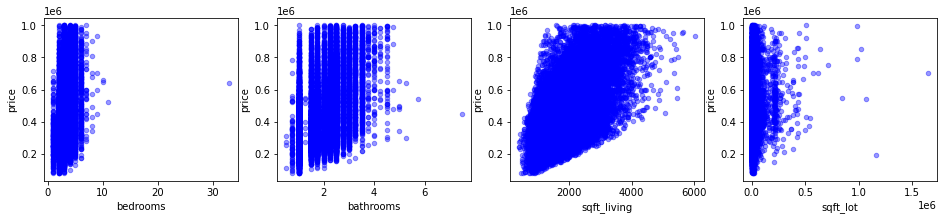

In [55]:
#scatter plot visualization (4 at a time so I can see them!)
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))

for xcol, ax in zip(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot'], axes):
    subset2.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

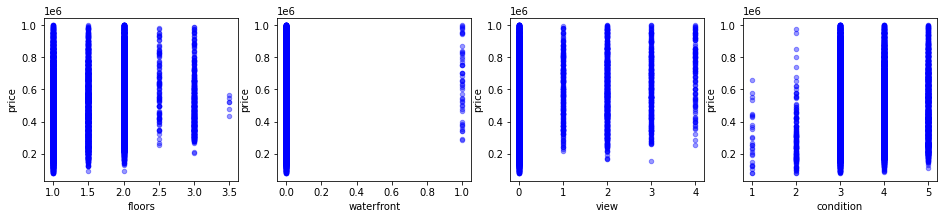

In [56]:
#scatter plot visualization (4 at a time so I can see them!)
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))

for xcol, ax in zip(['floors', 'waterfront', 'view', 'condition'], axes):
    subset2.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b') 
#all of these are categorical

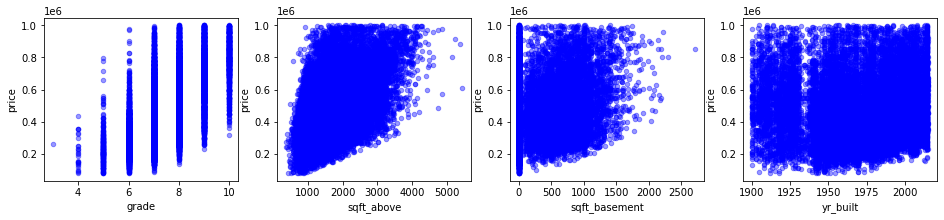

In [57]:
#scatter plot visualization (4 at a time so I can see them!)
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))

for xcol, ax in zip(['grade', 'sqft_above', 'sqft_basement', 'yr_built'], axes):
    subset2.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')  
#grade is categorical

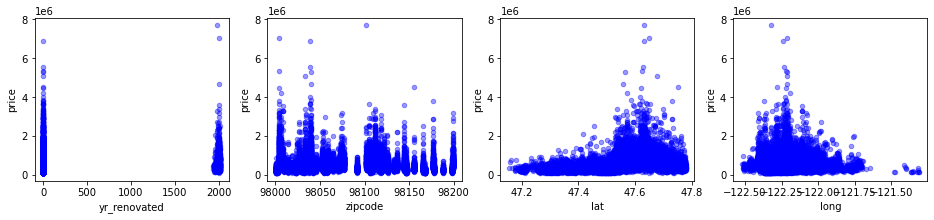

In [58]:
#scatter plot visualization (4 at a time so I can see them!)
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))

for xcol, ax in zip(['yr_renovated', 'zipcode', 'lat', 'long'], axes):
    mr_df.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')   
#yr_renovated

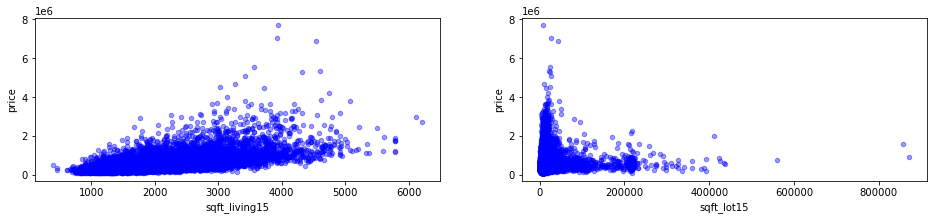

In [59]:
#scatter plot visualization (4 at a time so I can see them!)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,3))

for xcol, ax in zip(['sqft_living15', 'sqft_lot15'], axes):
    mr_df.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')  

### Shaving the Dataset Based on Problem Statement
From the scatter plots there are several categories that clearly have large outliers. I am going to remove them from this model as they do not represent the normative house. While this will ultimately make my model let acurate on the extremes of the housing market I believe it will allow me to build a more relevant model for the stake holder's purposes. I am also going to be treating the outliers by column individually, in the previously refered to notebooks I took a generalized 3 STD away from the mean approach.

In [60]:
#look at the bedroom values
subset2['bedrooms'].unique()  
#outlier = 33 bedrooms

array([ 3,  2,  4,  5,  1,  6,  7,  8,  9, 11, 10, 33], dtype=int64)

In [61]:
#locate the 33 bedroom column 
subset2.loc[subset2['bedrooms'] == 33]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15856,640000.0,33,1.75,1620,6000,1.0,0.0,0.0,5,7,1040,580.0,1947,0.0,98103,47.6878,-122.331,1330,4700


In [62]:
#uncomment to drop row 
subset2.drop([15856], inplace=True)

In [63]:
#look at the bathroom values
subset2['bathrooms'].unique() 

array([1.  , 2.25, 3.  , 2.  , 1.5 , 2.5 , 1.75, 2.75, 3.25, 4.  , 3.5 ,
       0.75, 4.25, 1.25, 3.75, 4.5 , 4.75, 5.  , 0.5 , 5.25, 7.5 , 5.75])

7.5 bathrooms, while possible is very high. This number of bathrooms is also only in one home and the next highest number of bathrooms is 5.75, 2 bathrooms less. It's an outliers I am going to drop.

In [64]:
subset2.loc[subset2['bathrooms'] == 7.5]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8537,450000.0,9,7.5,4050,6504,2.0,0.0,0.0,3,7,4050,0.0,1996,0.0,98144,47.5923,-122.301,1448,3866


In [65]:
#uncomment to drop row
subset2.drop([8537], inplace=True)

In [66]:
subset2

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,3,2.50,1530,1131,3.0,0.0,0.0,3,8,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,400000.0,4,2.50,2310,5813,2.0,0.0,0.0,3,8,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,402101.0,2,0.75,1020,1350,2.0,0.0,0.0,3,7,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,400000.0,3,2.50,1600,2388,2.0,0.0,0.0,3,8,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


In [67]:
subset2.loc[subset2['sqft_living'] < 5000] 
#all but 17 houses fall below the 5000 sqft marker I am going to remove those from the grouping 

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,3,2.50,1530,1131,3.0,0.0,0.0,3,8,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,400000.0,4,2.50,2310,5813,2.0,0.0,0.0,3,8,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,402101.0,2,0.75,1020,1350,2.0,0.0,0.0,3,7,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,400000.0,3,2.50,1600,2388,2.0,0.0,0.0,3,8,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


In [68]:
subset2.loc[subset2['sqft_living'] > 5000] 

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
577,930000.0,4,4.00,6050,84942,2.5,0.0,2.0,3,9,4150,1900.0,2009,0.0,98077,47.7466,-122.029,2700,199504
1620,610000.0,4,3.25,5450,37058,1.5,0.0,0.0,5,9,5450,0.0,1984,0.0,98042,47.3510,-122.087,2800,35716
2381,650000.0,5,3.50,5110,10018,2.0,0.0,0.0,3,10,3850,1260.0,2003,0.0,98034,47.7261,-122.170,1790,10018
3228,965000.0,4,3.25,5010,49222,2.0,0.0,0.0,5,9,3710,1300.0,1978,0.0,98027,47.5489,-122.092,3140,54014
3717,884900.0,7,4.75,5370,10800,1.5,0.0,0.0,3,8,5370,0.0,1967,0.0,98040,47.5380,-122.223,2310,10910
3950,700000.0,4,3.50,5360,25800,1.0,0.0,0.0,3,9,3270,2090.0,1971,0.0,98074,47.6099,-122.054,2650,21781
6622,850000.0,4,2.75,5440,239580,1.0,0.0,0.0,2,9,2720,2720.0,1969,0.0,98001,47.3540,-122.293,1970,40392
7273,800000.0,6,4.25,5480,189050,2.0,0.0,0.0,4,10,5140,340.0,1991,0.0,98031,47.4120,-122.168,2470,10429
7538,915000.0,4,4.50,5250,48352,2.0,0.0,0.0,3,10,5250,0.0,1998,0.0,98059,47.4858,-122.111,2500,48352
8188,955000.0,4,4.25,5660,193593,2.0,0.0,0.0,3,10,4100,1560.0,2001,0.0,98019,47.7064,-121.981,3620,207141


In [69]:
#uncomment to drop 
subset2.drop([577, 1620, 2381, 3228, 3717, 3950, 6622, 7273, 7538, 8188, 8337, 8355, 10968, 12005, 19809, 20280, 20876], inplace=True)

In [70]:
subset2

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,3,2.50,1530,1131,3.0,0.0,0.0,3,8,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,400000.0,4,2.50,2310,5813,2.0,0.0,0.0,3,8,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,402101.0,2,0.75,1020,1350,2.0,0.0,0.0,3,7,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,400000.0,3,2.50,1600,2388,2.0,0.0,0.0,3,8,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


In [71]:
subset2.loc[subset2["sqft_lot"] > 1000000] 
#there are 4 houses (farms really!) that are more than 1,000,000 sqft these are not the type of homes we will be dealing with

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1717,700000.0,4,1.00,1300,1651359,1.0,0.0,3.0,4,6,1300,0.0,1920,0.0,98022,47.2313,-122.023,2560,425581
7640,542500.0,5,3.25,3010,1074218,1.5,0.0,0.0,5,8,2010,1000.0,1931,0.0,98027,47.4564,-122.004,2450,68825
7762,855000.0,4,3.50,4030,1024068,2.0,0.0,0.0,3,10,4030,0.0,2006,0.0,98045,47.4619,-121.744,1830,11700
17305,190000.0,2,1.00,710,1164794,1.0,0.0,0.0,2,5,710,0.0,1915,0.0,98014,47.6888,-121.909,1680,16730


In [72]:
#uncomment to drop values
subset2.drop([1717, 7640, 7762, 17305], inplace=True)

In [73]:
subset2

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,3,2.50,1530,1131,3.0,0.0,0.0,3,8,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,400000.0,4,2.50,2310,5813,2.0,0.0,0.0,3,8,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,402101.0,2,0.75,1020,1350,2.0,0.0,0.0,3,7,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,400000.0,3,2.50,1600,2388,2.0,0.0,0.0,3,8,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


In [74]:
#located sqft_above above a threshold
subset2.loc[subset2["sqft_above"] > 4500]  
#nost of the homes with more than 4500 swft of living are at the upper threshold price range set, visually this threshold 
#makes sense too 

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
532,970000.0,4,3.25,4740,76230,2.0,0.0,0.0,3,10,4740,0.0,1987,0.0,98075,47.5931,-122.071,3340,49206
2409,487000.0,6,3.25,4750,248600,2.0,0.0,0.0,4,8,4750,0.0,1947,0.0,98022,47.1879,-121.973,2230,311610
3268,800000.0,4,2.50,4600,67369,2.0,0.0,0.0,3,10,4600,0.0,1990,0.0,98053,47.6417,-121.992,4600,67369
4019,960000.0,4,3.50,4610,11676,2.0,0.0,0.0,3,10,4610,0.0,2000,0.0,98075,47.6011,-121.983,3900,11164
9450,569950.0,5,4.50,4850,40902,2.0,0.0,0.0,3,10,4850,0.0,2001,0.0,98023,47.3181,-122.344,1640,13503
11871,975000.0,5,4.00,4850,36450,2.0,0.0,0.0,3,10,4850,0.0,1977,0.0,98005,47.6426,-122.158,3850,35325
16863,750000.0,3,3.25,4610,81935,2.0,0.0,0.0,4,9,4610,0.0,1984,0.0,98074,47.6217,-122.021,2900,43500


In [75]:
#uncomment to drop values
subset2.drop([532, 2409, 3268, 4019, 9450, 11871, 16863], inplace=True)

In [76]:
subset2

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,3,2.50,1530,1131,3.0,0.0,0.0,3,8,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,400000.0,4,2.50,2310,5813,2.0,0.0,0.0,3,8,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,402101.0,2,0.75,1020,1350,2.0,0.0,0.0,3,7,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,400000.0,3,2.50,1600,2388,2.0,0.0,0.0,3,8,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


In [77]:
#located sqft_basement above a threshold
subset2.loc[subset2["sqft_basement"] > 2200]   
#only 2 values above this threshold

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
14845,805000.0,5,2.50,4600,19831,1.0,0.0,3.0,3,9,2300,2300.0,1956,2015.0,98177,47.7608,-122.378,2890,19831
19247,959000.0,6,3.25,4440,17424,1.0,0.0,1.0,4,9,2220,2220.0,1959,0.0,98040,47.5791,-122.230,2660,10768


In [78]:
#uncomment to drop values
subset2.drop([14845, 19247], inplace=True)

In [79]:
subset2

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,3,2.50,1530,1131,3.0,0.0,0.0,3,8,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,400000.0,4,2.50,2310,5813,2.0,0.0,0.0,3,8,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,402101.0,2,0.75,1020,1350,2.0,0.0,0.0,3,7,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,400000.0,3,2.50,1600,2388,2.0,0.0,0.0,3,8,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


In [80]:
#located lat above a threshold
subset2.loc[subset2["lat"] > 47.7775]   
#after a visual inspection of a map these properties fall on the far norther edge of the king county border with saconma 
#county

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
306,550000.0,4,2.75,1800,7750,1.0,0.0,0.0,4,8,1400,400.0,1965,0.0,98177,47.7776,-122.384,1800,8275
15752,407500.0,4,2.50,1900,9075,2.0,0.0,0.0,3,7,1900,0.0,1988,0.0,98133,47.7776,-122.352,1800,8460
17450,389950.0,3,1.75,1580,9049,1.0,0.0,0.0,3,8,1580,0.0,1966,0.0,98177,47.7776,-122.375,2100,8446


In [81]:
#uncomment to drop values
subset2.drop([306, 15752, 17450], inplace=True)

In [82]:
subset2

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,3,2.50,1530,1131,3.0,0.0,0.0,3,8,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,400000.0,4,2.50,2310,5813,2.0,0.0,0.0,3,8,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,402101.0,2,0.75,1020,1350,2.0,0.0,0.0,3,7,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,400000.0,3,2.50,1600,2388,2.0,0.0,0.0,3,8,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


In [172]:
#### locate values on far eastern side of county 
subset2.loc[(subset2["long"] > -121.5) & (subset2["long"] < -120)]   

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2587,134000.0,2,1.50,980,5000,2.0,0.0,0.0,3,7,980,0.0,1922,2003.0,98014,47.7076,-121.359,1040,5000
2925,167000.0,1,1.00,780,10235,1.5,0.0,0.0,3,6,780,0.0,1989,0.0,98014,47.7130,-121.315,930,10165
4199,150000.0,3,0.75,490,38500,1.5,0.0,0.0,4,5,490,0.0,1959,0.0,98014,47.7112,-121.315,800,18297
4844,525000.0,3,2.75,2100,10362,2.0,0.0,0.0,3,9,1510,590.0,1998,0.0,98045,47.4347,-121.417,2240,11842
5861,175000.0,2,1.75,1050,9800,1.5,0.0,0.0,4,6,1050,0.0,1975,0.0,98019,47.7595,-121.473,1230,12726
6083,150000.0,3,1.00,890,6488,1.5,0.0,0.0,3,5,890,0.0,1928,0.0,98014,47.7087,-121.352,1330,16250
10084,200000.0,2,1.75,1320,13052,1.5,0.0,0.0,3,7,1320,0.0,1980,0.0,98014,47.7120,-121.352,1320,13052
10886,241000.0,2,1.75,1070,9750,1.5,0.0,0.0,3,7,1070,0.0,1995,0.0,98014,47.7131,-121.319,970,9750
13059,155000.0,2,1.00,1010,43056,1.5,0.0,0.0,3,5,1010,0.0,1990,0.0,98014,47.7105,-121.316,830,18297
13236,375000.0,3,1.75,2140,13598,1.5,0.0,0.0,4,7,1620,520.0,1970,0.0,98014,47.7139,-121.321,930,10150


In [173]:
#uncomment to drop values
subset2.drop([2587, 2925, 4199, 4844, 5861, 6083, 10084, 10886, 13059, 13236, 13981, 14601, 16828, 16927, 19634, 19964, 21370], inplace=True)   

#### Revisualize Data Dispersal

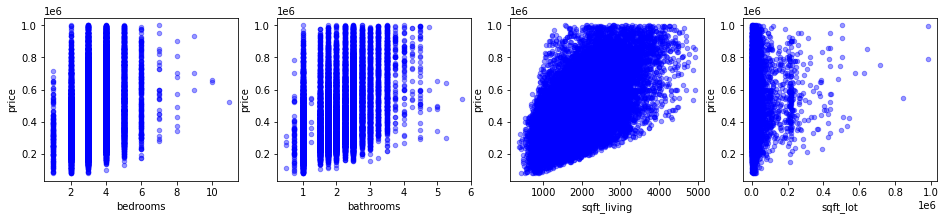

In [174]:
#scatter plot visualization (4 at a time so I can see them!)
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))

for xcol, ax in zip(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot'], axes):
    subset2.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

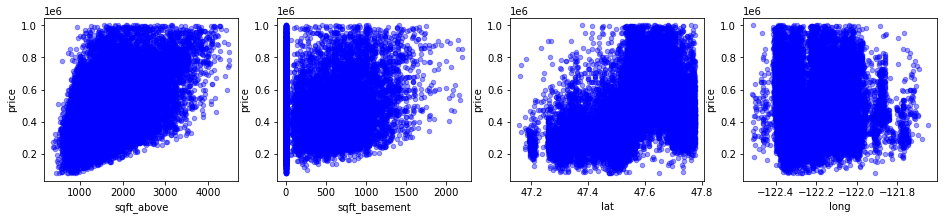

In [175]:
#scatter plot visualization (4 at a time so I can see them!)
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))

for xcol, ax in zip(['sqft_above', 'sqft_basement', 'lat', 'long'], axes):
    subset2.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

In [176]:
subset2

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,3,2.50,1530,1131,3.0,0.0,0.0,3,8,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,400000.0,4,2.50,2310,5813,2.0,0.0,0.0,3,8,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,402101.0,2,0.75,1020,1350,2.0,0.0,0.0,3,7,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,400000.0,3,2.50,1600,2388,2.0,0.0,0.0,3,8,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


It looks like there are still som outliers to treat with bedrooms, bathrooms, sqft_lot. I am going to re trim the data in those columns.

#### Resubset Data

In [177]:
#bedrooms above new threshold 
subset2.loc[subset2['bedrooms'] > 4]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
14,530000.0,5,2.00,1810,4850,1.5,0.0,0.0,3,7,1810,0.0,1900,0.0,98107,47.6700,-122.394,1360,4850
22,285000.0,5,2.50,2270,6300,2.0,0.0,0.0,3,8,2270,0.0,1995,0.0,98092,47.3266,-122.169,2240,7005
42,861990.0,5,2.75,3595,5639,2.0,0.0,0.0,3,9,3595,0.0,2014,0.0,98053,47.6848,-122.016,3625,5639
51,345000.0,5,2.50,3150,9134,1.0,0.0,0.0,4,8,1640,1510.0,1966,0.0,98056,47.4934,-122.189,1990,9133
54,920000.0,5,2.25,2730,6000,1.5,0.0,0.0,3,8,2130,600.0,1927,0.0,98105,47.6571,-122.281,2730,6000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21506,462500.0,6,3.00,2390,4000,2.0,0.0,0.0,3,7,2390,0.0,2014,0.0,98118,47.5173,-122.286,1680,5000
21544,540000.0,5,2.50,3370,4850,2.0,0.0,0.0,3,9,3370,0.0,2007,0.0,98056,47.5078,-122.169,2900,5570
21545,750000.0,5,4.00,4500,8130,2.0,0.0,0.0,3,10,4500,0.0,2007,0.0,98059,47.4832,-122.145,2840,8402
21548,579950.0,5,2.75,3080,5752,2.0,0.0,0.0,3,9,3080,0.0,2014,0.0,98059,47.4922,-122.153,3000,4650


In [178]:
#uncomment to remove  
subset2.drop([11973, 14309, 15827, 16999], inplace=True)

In [179]:
subset2

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,3,2.50,1530,1131,3.0,0.0,0.0,3,8,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,400000.0,4,2.50,2310,5813,2.0,0.0,0.0,3,8,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,402101.0,2,0.75,1020,1350,2.0,0.0,0.0,3,7,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,400000.0,3,2.50,1600,2388,2.0,0.0,0.0,3,8,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


In [180]:
#bedrooms above new threshold 
subset2.loc[subset2['bathrooms'] > 3.25]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
75,832500.0,4,4.0,3430,35102,2.0,0.0,0.0,4,10,2390,1040.0,1986,0.0,98075,47.5822,-121.987,3240,35020
115,740500.0,3,3.5,4380,6350,2.0,0.0,0.0,3,8,2780,0.0,1900,0.0,98117,47.6981,-122.368,1830,6350
116,518500.0,3,3.5,1590,1102,3.0,0.0,0.0,3,8,1590,0.0,2010,0.0,98103,47.6824,-122.347,1620,3166
128,822500.0,5,3.5,2320,4960,2.0,0.0,0.0,5,7,1720,600.0,1926,0.0,98103,47.6763,-122.352,1700,4960
132,784000.0,3,3.5,3950,111078,1.5,0.0,0.0,3,9,2460,1490.0,1989,0.0,98052,47.6970,-122.072,2480,88500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21483,850000.0,5,3.5,4200,5400,2.0,0.0,0.0,3,9,3140,1060.0,2012,0.0,98052,47.7077,-122.120,3300,5564
21487,735000.0,4,3.5,2340,2810,2.0,0.0,2.0,3,8,1730,610.0,2011,0.0,98027,47.5403,-122.028,2600,2843
21545,750000.0,5,4.0,4500,8130,2.0,0.0,0.0,3,10,4500,0.0,2007,0.0,98059,47.4832,-122.145,2840,8402
21555,608500.0,4,3.5,2850,5577,2.0,0.0,0.0,3,8,1950,900.0,2014,0.0,98056,47.5252,-122.192,2850,5708


In [183]:
print(subset2["sqft_lot"].mean())
print(subset2["sqft_lot"].median())

14067.842985971944
7490.0


Theres a huge difference between the mean and median of the sqft of these houses I am going to look at what threshold would get those two closer together.

In [ ]:
sq_ft_threshold = subset2.loc[subset2['sqft_lot'] < 20000] 

In [ ]:
sq_ft_threshold['sqft_lot'].mean()

In [ ]:
sq_ft_threshold['sqft_lot'].median()

Looking at the data I would have to loose over 10,000 rows in order to make the mean and median more even. I am going to log transform the remaining columns instead to preserve those. 

#### Revisualize Data 

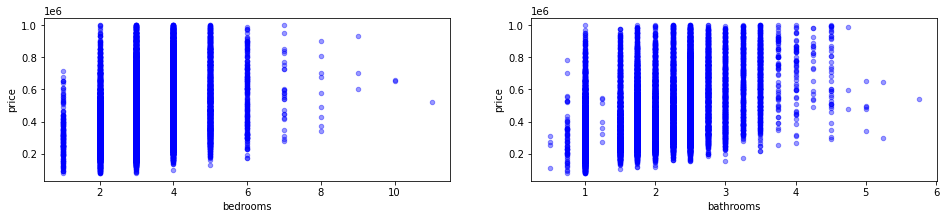

In [185]:
#scatter plot visualization (4 at a time so I can see them!)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,3))

for xcol, ax in zip(['bedrooms', 'bathrooms'], axes):
    subset2.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

I am still not satisfied with that threshold 

In [189]:
subset2.loc[subset2['bedrooms'] > 8] 
subset2.drop([4092, 4231, 8748, 15147, 18428, 19239], inplace=True)

In [192]:
subset2.loc[subset2['bathrooms'] > 4.5] 
subset2.drop([1434, 1658, 2343, 4594, 5205, 12216, 15737, 16789, 19640, 20968, 21267], inplace=True)

#### Revisualize Data 

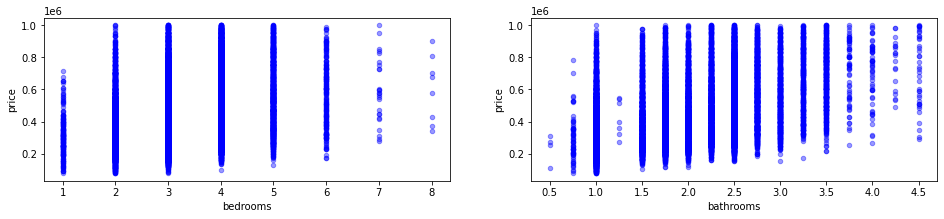

In [194]:
#scatter plot visualization (4 at a time so I can see them!)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,3))

for xcol, ax in zip(['bedrooms', 'bathrooms'], axes):
    subset2.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

### Categorical Variables

#### Dummify Waterfront 
Create either they a waterfront view or they do not

In [199]:
#create a dummy waterfront
waterfront_dummies = pd.get_dummies(subset2['waterfront'], prefix='wf', drop_first=True)

In [200]:
subset3 = pd.concat([subset2, waterfront_dummies], axis=1)
#if it has a 1 that means there is a waterfront view 

In [202]:
subset3.drop(['waterfront'], axis=1)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,wf_1.0
0,221900.0,3,1.00,1180,5650,1.0,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,0
1,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,0
2,180000.0,2,1.00,770,10000,1.0,0.0,3,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062,0
3,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,0
4,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,3,2.50,1530,1131,3.0,0.0,3,8,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509,0
21593,400000.0,4,2.50,2310,5813,2.0,0.0,3,8,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200,0
21594,402101.0,2,0.75,1020,1350,2.0,0.0,3,7,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007,0
21595,400000.0,3,2.50,1600,2388,2.0,0.0,3,8,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287,0


In [242]:
subset4 = subset3.drop(['waterfront'], axis=1)

In [259]:
subset4['wf_1.0'] = subset4['wf_1.0'].astype(int)

In [261]:
subset4['wf'] = subset4['wf_1.0']

In [266]:
subset5 = subset4.drop(['wf_1.0'], axis=1)

#### Dummify "yr_renovated"  
Only 500 houses have been renovated at all, while it still a helpful metric I think that the year it was renvoated doesn't affect the model.

In [ ]:
#map a 1 if renovated 0 if not 
subset5['yr_renovated'] = subset5['yr_renovated'].map(lambda x: '1' if x < 1 else '0')

#### Dummify "view"
The view coloumn denotes a view rating, I am going to dummify it if it has a view worth noting it will be a 1 otherwise 0

In [206]:
subset5['view'] = subset5['view'].map(lambda x: '1' if x > 1 else '0')

## Feature Scaling & Normalization

In [286]:
subset5.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built',
       'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
       'wf'],
      dtype='object')

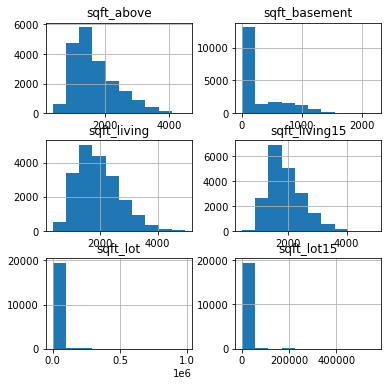

In [287]:
subset5[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']].hist(figsize  = [6, 6]); 

Issues with skewness in all of them and variation in magnitude.

## Run Linear Regression

### Trial 1

In [263]:
#define problem
outcome = "price"
t1 = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'wf']

In [274]:
#baseline model 
y = subset5[['price']]
X = subset5.drop(['price'], axis=1) 

regression = LinearRegression()
crossvalidation = KFold(n_splits=3, shuffle=True, random_state=1) 
    
baseline= np.mean(cross_val_score(regression, X, y, scoring='r2', cv=crossvalidation))
print("Baseline:", baseline)

Baseline: 0.6830529923464006


#### Investigate Mulitcollinearity

In [264]:
correlation_df = subset5.corr() 
correlation_df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,wf_1.0,wf
price,1.000000,0.287828,0.431358,0.596095,0.095975,0.263121,0.037048,0.606605,0.502606,0.218808,0.052590,-0.016211,0.446722,0.078952,0.537697,0.075005,0.051305,0.051305
bedrooms,0.287828,1.000000,0.494979,0.605768,0.021180,0.152475,0.023301,0.323256,0.475762,0.279239,0.169700,-0.158075,-0.038136,0.157100,0.382033,0.016199,-0.029434,-0.029434
bathrooms,0.431358,0.494979,1.000000,0.705834,0.062242,0.503046,-0.138055,0.605100,0.624814,0.207209,0.554984,-0.213796,-0.017222,0.259658,0.518054,0.054003,-0.009466,-0.009466
sqft_living,0.596095,0.605768,0.705834,1.000000,0.164101,0.332818,-0.070754,0.684586,0.843598,0.365230,0.357316,-0.210633,0.001131,0.299110,0.729765,0.162049,0.001366,0.001366
sqft_lot,0.095975,0.021180,0.062242,0.164101,1.000000,-0.022800,-0.002143,0.095978,0.169131,0.007665,0.050313,-0.136133,-0.104348,0.233045,0.152069,0.740948,0.030349,0.030349
floors,0.263121,0.152475,0.503046,0.332818,-0.022800,1.000000,-0.278383,0.457189,0.529173,-0.301852,0.515006,-0.065860,0.031922,0.136592,0.261014,-0.028213,-0.007408,-0.007408
condition,0.037048,0.023301,-0.138055,-0.070754,-0.002143,-0.278383,1.000000,-0.171382,-0.178753,0.174030,-0.349430,-0.008571,-0.019073,-0.096229,-0.119011,0.004393,0.009529,0.009529
grade,0.606605,0.323256,0.605100,0.684586,0.095978,0.457189,-0.171382,1.000000,0.688721,0.060646,0.501534,-0.189743,0.077987,0.237400,0.650317,0.092722,-0.013199,-0.013199
sqft_above,0.502606,0.475762,0.624814,0.843598,0.169131,0.529173,-0.178753,0.688721,1.000000,-0.182442,0.467041,-0.277174,-0.056646,0.403775,0.705979,0.167194,-0.009915,-0.009915
sqft_basement,0.218808,0.279239,0.207209,0.365230,0.007665,-0.301852,0.174030,0.060646,-0.182442,1.000000,-0.150623,0.092379,0.099731,-0.148589,0.113945,0.005851,0.020481,0.020481


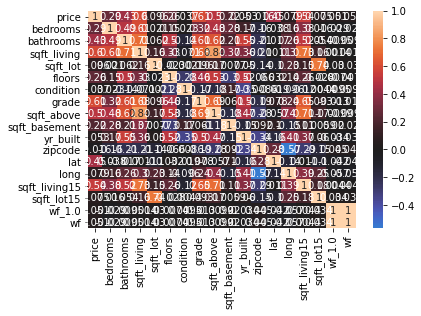

In [265]:
sns.heatmap(correlation_df, center=0, annot=True) 

In [278]:
#correlation above 0.75 is highly correlated
abs(subset5.corr()) > 0.75

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,wf
price,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bedrooms,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_living,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False
sqft_lot,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
floors,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
condition,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
grade,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
sqft_above,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False
sqft_basement,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False


In [280]:
#Check for correlation numerically
df=subset5.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
df['pairs'] = list(zip(df.level_0, df.level_1))

# set index to pairs
df.set_index(['pairs'], inplace = True)

#d rop level columns
df.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
df.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
df.drop_duplicates(inplace=True)

In [281]:
df[(df.cc>.75) & (df.cc <1)]

,cc
pairs,
"(sqft_living, sqft_above)",0.843598


This check from the curriculum confirms what I saw visually in the first check the only two highly correlated here are sqft_living and sqft_above. 

### Trial 2 
Remove 'sqft_above' to reduce multicollinearity 
Baseline: 0.6830529923464006

In [284]:
#redefine problem
outcome = "price"
t2 = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'view', 'condition', 'grade', 'zipcode',
       'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'wf']

In [285]:
#fit model 
predictors = '+'.join(t2) 
formula = outcome + "~" + predictors
model = ols(formula=formula, data=subset5).fit()
model.summary()  

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.684
Model:                            OLS   Adj. R-squared:                  0.684
Method:                 Least Squares   F-statistic:                     2540.
Date:                Thu, 08 Oct 2020   Prob (F-statistic):               0.00
Time:                        19:50:18   Log-Likelihood:            -2.5957e+05
No. Observations:               19943   AIC:                         5.192e+05
Df Residuals:                   19925   BIC:                         5.193e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -6.726e+06   1.65e+06     -4.075      0.000   -9.96e+06   -3.49e+06
view[T.1]          6.193e+04   3479.546     17.797      0.000    5.51e+04    6.87e+04
yr_renovated[T.1] -2.681e+04   4762.196     -5.629      0.000   -3.61e+04   -1.75e+04
bedrooms          -1.061e+04   1163.869     -9.114      0.000   -1.29e+04   -8326.684
bathrooms           2.39e+04   1925.238     12.413      0.000    2.01e+04    2.77e+04
sqft_living          70.8243      2.373     29.851      0.000      66.174      75.475
sqft_lot              0.3041      0.033      9.277      0.000       0.240       0.368
floors              3.16e+04   2072.478     15.245      0.000    2.75e+04    3.57e+04
condition          2.443e+04   1322.447     18.476      0.000    2.18e+04     2.7e+04
grade              7.029e+04   1282.391     54.810      0.000    6.78e+04    7.28e+04
zipcode            -197.1900     18.616    -10.593      0.000    -233.679    -160.701
sqft_basement        -0.6775      2.649     -0.256      0.798      -5.869       4.514
yr_built          -1781.3596     41.867    -42.548      0.000   -1863.422   -1699.297
lat                 5.36e+05   5927.678     90.417      0.000    5.24e+05    5.48e+05
long               -3.01e+04   7501.007     -4.013      0.000   -4.48e+04   -1.54e+04
sqft_living15        46.4822      2.149     21.626      0.000      42.269      50.695
sqft_lot15           -0.1798      0.046     -3.911      0.000      -0.270      -0.090
wf                  1.81e+05   1.59e+04     11.367      0.000     1.5e+05    2.12e+05
==============================================================================
Omnibus:                     1115.682   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1713.058
Skew:                           0.481   Prob(JB):                         0.00
Kurtosis:                       4.067   Cond. No.                     2.15e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.15e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This improved our R2 slightly!

In [277]:
#vif scores
X = subset5[t2] 
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]  
vif

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [255]:
def linear_regression(x_cols, df, outcome='price'):  

    #vif scores
    X = df[x_cols] 
    vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]  
    
    #normality check
    fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)  

# Working Line

In [247]:
subset5 = [t[0] for t in correlation_df if t[1] >= 0.20]
subset5

TypeError: '>=' not supported between instances of 'str' and 'float'